[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'AMZN'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High',  'AMZN'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low',  'AMZN'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open',  'AMZN'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume',  'AMZN'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])


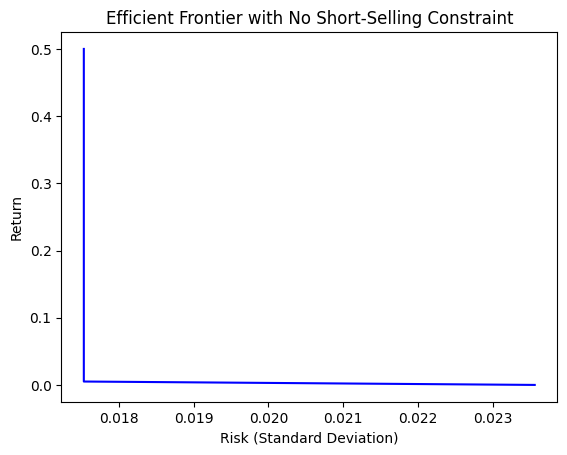

<ipython-input-40-555cc6dc2aa5>:93: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  results[2, i] = sharpe_ratio


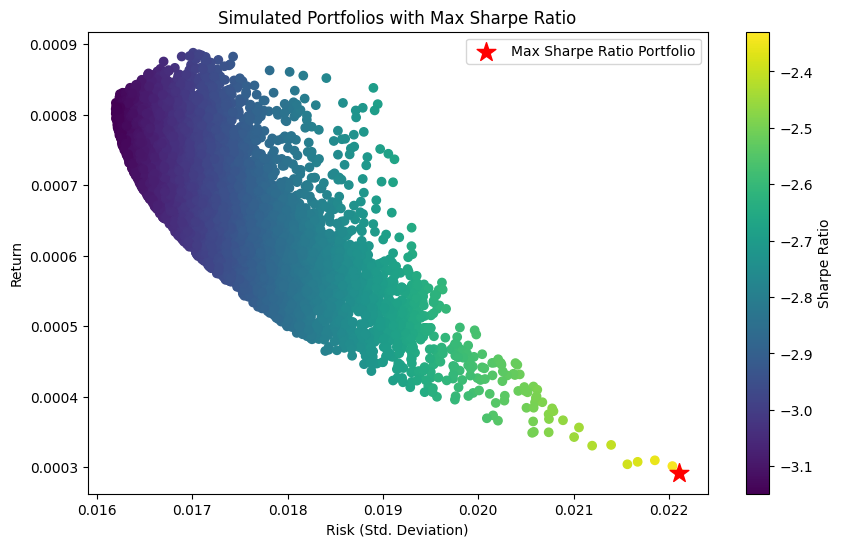

[*********************100%***********************]  1 of 1 completed

Optimal portfolio weights for Max Sharpe Ratio Portfolio:
AAPL: 4.02%
MSFT: 87.40%
GOOGL: 2.74%
AMZN: 5.84%
Portfolio Maximum Drawdown: {max_drawdown:.2%}


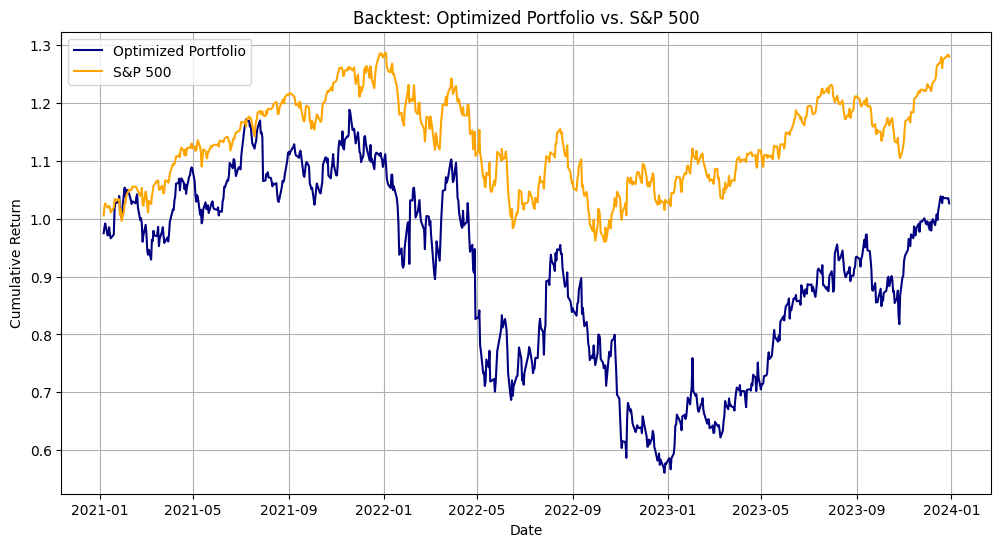

Portfolio CAGR: 0.89%
Portfolio Volatility: 35.12%
Portfolio Sharpe Ratio: nan
(751,)
Checking for NaN values in returns data:
Portfolio NaN values: 0
Market NaN values: 0
Portfolio Sharpe Ratio: 0.0126


FloatSlider(value=0.5, description='Risk Tolerance:', max=1.0, step=0.01)

In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Download stock data for the tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start='2021-01-01', end='2024-01-01')

# Print column names to confirm the correct data is fetched
print(data.columns)

# Use only 'Close' price data for analysis
data = data['Close']

# Drop rows with missing values to ensure clean data
data = data.dropna()

# Calculate daily returns (percentage change)
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean().to_numpy()  # Expected returns
cov_matrix = returns.cov().to_numpy()    # Covariance matrix of returns

# Dynamic risk-free rate (e.g., 10-year Treasury bond yield)
rf_data = yf.download('^IRX', start='2021-01-01', end='2024-01-01')
rf = rf_data['Close'].iloc[-1] / 100  # Convert to decimal form (e.g., 5% = 0.05)

# Define the portfolio optimization objective (minimize risk)
def objective(weights, mean_returns, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))  # Minimize risk (variance)

# Define the constraint: sum of weights should equal 1 (fully invested)
def constraint(weights):
    return np.sum(weights) - 1

# Set bounds for the weights (no short-selling)
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial guess: equally distributed weights
initial_guess = len(tickers) * [1. / len(tickers)]

# Portfolio optimization function
def optimize_portfolio(target_return):
    # Create constraint for target return
    constraint_return = {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - target_return}
    # Use 'SLSQP' method for constrained optimization
    result = minimize(objective, initial_guess, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=[constraint_return, {'type': 'eq', 'fun': constraint}])
    return result.x

# Function to calculate portfolio performance (return, risk)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_stddev

# Efficient frontier: Visualize portfolio return vs. risk
target_returns = np.linspace(0, 0.5, 100)
efficient_risks = []

# Loop through different target returns to calculate risk (std. deviation)
for target_return in target_returns:
    optimized_weights = optimize_portfolio(target_return)
    portfolio_return, portfolio_stddev = portfolio_performance(optimized_weights, mean_returns, cov_matrix)
    efficient_risks.append(portfolio_stddev)

# Plot the efficient frontier
plt.plot(efficient_risks, target_returns, label="Efficient Frontier", color="blue")
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier with No Short-Selling Constraint')
plt.show()

# Monte Carlo Simulation to find optimal portfolio
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # To store return, risk, and Sharpe ratio
weights_record = []

# Simulate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # Normalize to ensure weights sum to 1
    weights_record.append(weights)

    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_stddev  # Adjusted for risk-free rate

    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio

# Convert results to DataFrame
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe Ratio'])
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()  # Index of portfolio with highest Sharpe ratio
optimal_weights = weights_record[max_sharpe_idx]  # Optimal weights for the best Sharpe ratio

# Plot the simulated portfolios and highlight the max Sharpe ratio portfolio
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results_df.loc[max_sharpe_idx, 'Risk'], results_df.loc[max_sharpe_idx, 'Return'],
            color='r', marker='*', s=200, label='Max Sharpe Ratio Portfolio')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.title('Simulated Portfolios with Max Sharpe Ratio')
plt.legend()
plt.show()

# Display the optimal portfolio weights for the max Sharpe ratio portfolio
print("Optimal portfolio weights for Max Sharpe Ratio Portfolio:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.2%}")

# Additional risk metrics: Value at Risk (VaR) and Maximum Drawdown

# Value at Risk (VaR) at 95% confidence
def calculate_var(returns, confidence_level=0.95):
    return np.percentile(returns, (1 - confidence_level) * 100)

# Maximum Drawdown
def calculate_max_drawdown(data):
    cumulative_returns = (1 + data).cumprod()  # Calculate cumulative returns
    peak = cumulative_returns.cummax()  # Find the peak value
    drawdown = (cumulative_returns - peak) / peak  # Calculate drawdown
    return drawdown.min()  # Return the lowest drawdown (i.e., maximum drawdown)

# Calculate maximum drawdown for the portfolio
max_drawdown = calculate_max_drawdown(returns)

# Print the maximum drawdown as a percentage
print("Portfolio Maximum Drawdown: {max_drawdown:.2%}")

# --- BACKTEST vs S&P 500 ---

# Download and process S&P 500 index data
sp500 = yf.download('^GSPC', start='2021-01-01', end='2024-01-01')['Close']
sp500 = sp500.loc[returns.index]
sp500_returns = sp500.pct_change().dropna()

# Calculate weighted portfolio returns
weighted_returns = returns.dot(optimal_weights)
weighted_returns = weighted_returns.loc[sp500_returns.index]

# Cumulative returns
portfolio_cum_returns = (1 + weighted_returns).cumprod()
sp500_cum_returns = (1 + sp500_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label='Optimized Portfolio', color='navy')
plt.plot(sp500_cum_returns, label='S&P 500', color='orange')
plt.title('Backtest: Optimized Portfolio vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# --- PERFORMANCE METRICS ---

def calculate_cagr(returns, periods_per_year=252):
    cumulative_return = (1 + returns).prod()
    n_periods = len(returns)
    return cumulative_return**(periods_per_year / n_periods) - 1

def calculate_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

def calculate_sharpe_ratio(returns, rf=rf, periods_per_year=252):
    excess_returns = returns - (rf / periods_per_year)
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(periods_per_year)

# Portfolio metrics
portfolio_cagr = calculate_cagr(weighted_returns)
portfolio_vol = calculate_volatility(weighted_returns)
portfolio_sharpe = calculate_sharpe_ratio(weighted_returns)

print(f"Portfolio CAGR: {portfolio_cagr:.2%}")
print(f"Portfolio Volatility: {portfolio_vol:.2%}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")

print(weighted_returns.shape)  # To verify its shape


# Convert weighted_returns and sp500_returns to NumPy arrays and flatten them
weighted_returns_flat = np.array(weighted_returns).flatten()
sp500_returns_flat = np.array(sp500_returns).flatten()

# Check for NaN values in portfolio returns and market returns
print("Checking for NaN values in returns data:")
print(f"Portfolio NaN values: {np.isnan(weighted_returns_flat).sum()}")
print(f"Market NaN values: {np.isnan(sp500_returns_flat).sum()}")

# Drop any rows with NaN values in either portfolio or market returns
aligned_data = pd.DataFrame({
    'Portfolio': weighted_returns_flat,
    'Market': sp500_returns_flat
}).dropna()

# Recalculate the portfolio Sharpe ratio, assuming a risk-free rate of 0 for simplicity
portfolio_returns = aligned_data['Portfolio']
market_returns = aligned_data['Market']

# Check for a standard deviation of zero in portfolio returns
if portfolio_returns.std() == 0:
    print("Warning: Portfolio returns have zero standard deviation, cannot calculate Sharpe ratio.")
    sharpe_ratio = np.nan  # Set Sharpe ratio to NaN if standard deviation is zero
else:
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()

print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")

import ipywidgets as widgets
from IPython.display import display

# Create a slider widget for adjusting a parameter (e.g., risk tolerance)
risk_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Risk Tolerance:')
display(risk_slider)
